# Colab

In [1]:
from google.colab import auth, drive

auth.authenticate_user()
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
!pip install pandas
!pip install seaborn
!pip install matplotlib
!pip install sklearn

# NSMC Clustering
- 영화 리뷰에 대해 형태소 단위로 나눈 이후, 이를 이용화여 군집화 알고리즘 적용
- 영화 리뷰 중, 문장 길이가 짧은 리뷰와 문장 길이가 긴 리뷰를 나누어서 다음 과정을 진행
    1. 군집 개수(K) 를 임의로 설정하여 알고리즘을 실행한 이후, 리뷰들을 각 군집으로 분리
        - (이 때 이용되는 변수는 타당한 근거를 바탕으로 okt_res, komoran_res 중 1개로 선택)
    2. 분리된 각 군집에 대해서 많이 발생한 형태소를 계산하여, 각 군집에 대한 특징을 해석하기

# 모듈 불러오기

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pprint import pprint
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

# 데이터 불러오기

In [4]:
data = pd.read_csv("gdrive/My Drive/data/preprocessed_ratings.csv")

# 데이터 확인하기

In [5]:
data.head(10)
# id : 네이버 영화 리뷰의 식별번호
# document : 네이버 영화 리뷰 내용
# label : 긍정, 부정 레이블 (긍정 : 1, 부정 : 0)
# preprocessed_document : nsmc_preprocessing.ipynb 코드에서 처리된 내용 (글자 수 12이상 15 이하)
# document_len : preprocessed_document 글자 수
# okt_res : 트위터 형태소 처리 결과
# komoran_res : 코모란 형태소 처리 결과

,Unnamed: 0,id,document,label,preprocessed_document,document_len,okt_res,komoran_res
0,9,9250537,바보가 아니라 병 쉰 인듯,1,바보가아니라병쉰인듯,10,"['바보', '가', '아니라', '병', '쉰인듯']","['바보', '가', '아니', '라', '병', '쉬', 'ㄴ', '인', '듯']"
1,43,8719068,도법 멤버들 모두 기대됨,1,도법멤버들모두기대됨,10,"['도법', '멤버', '들', '모두', '기대', '됨']","['도법', '멤버', '들', '모두', '기대', '되', 'ㅁ']"
2,49,10272889,내용이너무좋아요.ㅎ,1,내용이너무좋아요ㅎ,9,"['내', '용이', '너무', '좋아요', 'ㅎ']",['내용이너무좋아요ㅎ']
3,58,1516658,내가 본 영화 중 영순위♥,1,내가본영화중영순위,9,"['내', '가본', '영화', '중', '영', '순위']","['내', '가', '보', 'ㄴ', '영화', '중', '영', '순위']"
4,59,8255656,재밌습니다.재밌습니다.,1,재밌습니다재밌습니다,10,"['재밌습니다', '재밌습니다']","['재밌', '습니다', '재밌', '습니다']"
5,60,4469803,상당히 훌륭한 영화...,1,상당히훌륭한영화,8,"['상당히', '훌륭한', '영화']",['상당히훌륭한영화']
6,73,8377531,우리나라 예능 중 최고!!,1,우리나라예능중최고,9,"['우리나라', '예능', '중', '최고']","['우리나라', '예능', '중', '최고']"
7,85,8095702,사실적이어서 더 극적인.,1,사실적이어서더극적인,10,"['사실', '적', '이어서', '더', '극적', '인']","['사실', '적', '이', '어서', '더', '극', '적', '이', 'ㄴ']"
8,86,10248728,뀰잼이다뀰잼이라구여,1,뀰잼이다뀰잼이라구여,10,"['뀰잼', '이다', '뀰잼', '이라', '구', '여']",['뀰잼이다뀰잼이라구여']
9,87,3812917,짱 재미있어요오> ㅇ <,1,짱재미있어요오ㅇ,8,"['짱', '재미있어요', '오', 'ㅇ']","['짱', '재미있', '어요', '옹']"


In [6]:
data.shape # 데이터 행과 열 개수 확인

(46081, 8)

# 영화 리뷰에 대해 형태소 길이를 계산하고 시각화를 통해 데이터를 탐색

In [7]:
okt_token_len = data["okt_res"].apply(lambda x: len(x.split(','))) # ,(comma) 기준으로 나누었을 때 형태소 단위로 분리되며 이에 대한 개수, 즉 형태소 개수를 계산하는 함수

In [8]:
tmp_df = pd.DataFrame({"okt_res" : data["okt_res"], "okt_token_len" : okt_token_len}) # 형태소 단위에 대해서 형태소 개수를 데이터 프레임으로 변환

In [9]:
tmp_df # 결과 확인

,okt_res,okt_token_len
0,"['바보', '가', '아니라', '병', '쉰인듯']",5
1,"['도법', '멤버', '들', '모두', '기대', '됨']",6
2,"['내', '용이', '너무', '좋아요', 'ㅎ']",5
3,"['내', '가본', '영화', '중', '영', '순위']",6
4,"['재밌습니다', '재밌습니다']",2
...,...,...
46076,"['나', '한테', '돈조반니', '천', '원', '한장', '이라도', '조반...",9
46077,"['심형래', '영화', '를', '보세요', '그건', '재미', '라도', '있죠']",8
46078,"['전', '다', '태우고', '막판', '에', '뒤집는다고', '전이', '되나']",8
46079,"['업로드', '좀빨', '리해', '라', '어제', '부터', '기다리는데']",7


Text(0.5, 1.0, 'The Distribution of Length over the Movie Reviews (okt Token)')

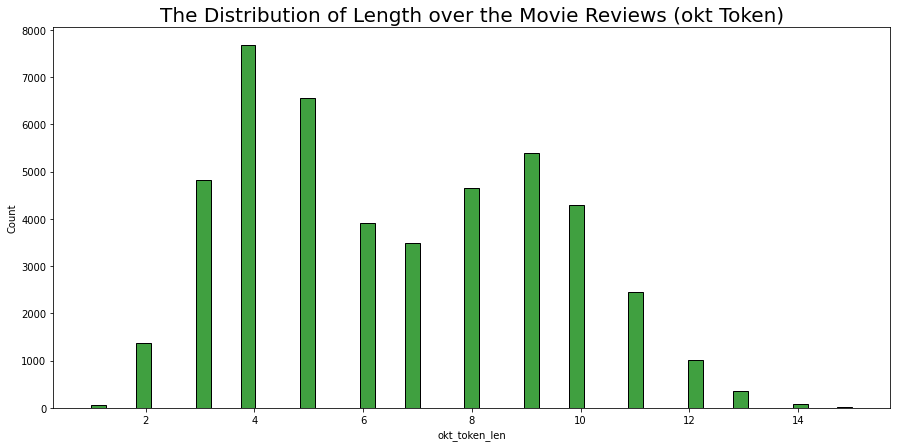

In [10]:
plt.rcParams["figure.figsize"] = (15, 7) # 그래프 크기 지정
sns.histplot(tmp_df["okt_token_len"], color = "green") # 단일 변량 분포 그래프
plt.title("The Distribution of Length over the Movie Reviews (okt Token)", fontsize = 20) # 그래프 제목, 글자 크기는 20 지정

# 문장 길이가 짧은 리뷰에 대해 어떠한 형태소가 많이 발생하였는지 계산하기
- CountVectorizer (예시)
    - 문장 (1) : 나는 너를 좋아한다.
    - 문장 (1) 형태소 분석기 결과 : '나', '너', '좋아함'
    
    - 문장 (2) : 너는 사과를 좋아한다.
    - 문장 (2) 형태소 분석기 결과 : '너', '사과', '좋아함'
    
    - 문장 (3) : 나는 사과를 좋아한다.
    - 문장 (3) 형태소 분석기 결과 : '나', '사과', '좋아함'

- CountVectorizer (결과) : ['나' '너' '좋아함' '사과']
    - 문장 (1) : [1, 1, 1, 0]
    - 문장 (2) : [0, 1, 1, 1]
    - 문장 (3) : [1, 0, 1, 1]

In [11]:
short_data = data[data["document_len"] <= 10] # 문장 길이가 짧은 리뷰 데이터만 추출
short_data # 데이터 확인

,Unnamed: 0,id,document,label,preprocessed_document,document_len,okt_res,komoran_res
0,9,9250537,바보가 아니라 병 쉰 인듯,1,바보가아니라병쉰인듯,10,"['바보', '가', '아니라', '병', '쉰인듯']","['바보', '가', '아니', '라', '병', '쉬', 'ㄴ', '인', '듯']"
1,43,8719068,도법 멤버들 모두 기대됨,1,도법멤버들모두기대됨,10,"['도법', '멤버', '들', '모두', '기대', '됨']","['도법', '멤버', '들', '모두', '기대', '되', 'ㅁ']"
2,49,10272889,내용이너무좋아요.ㅎ,1,내용이너무좋아요ㅎ,9,"['내', '용이', '너무', '좋아요', 'ㅎ']",['내용이너무좋아요ㅎ']
3,58,1516658,내가 본 영화 중 영순위♥,1,내가본영화중영순위,9,"['내', '가본', '영화', '중', '영', '순위']","['내', '가', '보', 'ㄴ', '영화', '중', '영', '순위']"
4,59,8255656,재밌습니다.재밌습니다.,1,재밌습니다재밌습니다,10,"['재밌습니다', '재밌습니다']","['재밌', '습니다', '재밌', '습니다']"
...,...,...,...,...,...,...,...,...
23800,199980,5535592,0점은 없나? 짜증나--,0,점은없나짜증나,7,"['점', '은', '없나', '짜증나']","['점', '은', '없', '나', '짜증', '나']"
23801,199989,5711373,재미없고 억지스럽다,0,재미없고억지스럽다,9,"['재미없고', '억지스럽다']","['재미없', '고', '억지', '스럽', '다']"
23802,199993,417815,음 왜 봤을까? 예고편이 다 -,0,음왜봤을까예고편이다,10,"['음왜', '봤을까', '예고편', '이다']","['음', '왜', '보', '았', '을', '까', '예고편', '이다']"
23803,199994,4834376,개연성이 없어요.. 별루다...,0,개연성이없어요별루다,10,"['개연', '성', '이', '없어', '요별', '루', '다']","['개연', '성', '이', '없', '어요', '별루', '다']"


In [12]:
print(short_data.shape)  # 데이터 행과 열 개수 확인

(23805, 8)


In [13]:
short_cv = CountVectorizer() # 형태소를 세는 객체 호출
short_corpus = short_data["okt_res"] # 트위터 형태소 처리 결과 추출
short_cv_res = short_cv.fit_transform(short_corpus) # 트위터 형태소 처리 결과에 대해서 형태소 개수 계산
short_cv_res_array = short_cv_res.toarray() # 계산된 결과를 배열 형태로 변환
short_cv_res_array # 결과 확인

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [14]:
short_cv_res_array.shape  # 데이터 행과 열 개수 확인

(23805, 16097)

In [15]:
short_cv.get_feature_names() # short_cv_res_array의 각 열 별 형태소 이름 확인

['ㄱㄱ',
 'ㄱㄱㄱ',
 'ㄱㄱㄱㄱㄱㄱㄱㄱ',
 'ㄱㄱㄷ',
 'ㄱㄴ',
 'ㄱㄴㄷ',
 'ㄱㄷㅋㄷㅈㅅㄱㄷ',
 'ㄱㅂㅋㄹㄱ',
 'ㄱㅅ',
 'ㄱㅇㅈㄴㅁㅅㄱㅅ',
 'ㄱㅈ',
 'ㄱㅈㄴㅍㄷㅇㅇ',
 'ㄱㅊ',
 'ㄱㅋ',
 'ㄲㄲㅑ',
 'ㄲㅈ',
 'ㄲㅋㅋ',
 'ㄲㅑ',
 'ㄴㄴ',
 'ㄴㄴㄴㄴㄴ',
 'ㄴㄷㅅ',
 'ㄴㄹ',
 'ㄴㅁ',
 'ㄴㅅ',
 'ㄴㅈ',
 'ㄷㄱ',
 'ㄷㄱㄷㄱㄷㄱㄷㄱ',
 'ㄷㄷ',
 'ㄷㄷㄷ',
 'ㄷㄷㄷㄷ',
 'ㄷㄷㄷㄷㄷ',
 'ㄷㄷㄷㄷㄷㄷ',
 'ㄷㄷㅋㅋ',
 'ㄷㅃㅅㅊㅎㄱㅅ',
 'ㄷㅅ',
 'ㄷㅐ',
 'ㄹㄴ',
 'ㄹㄹ',
 'ㄹㄹㄹㄹㄹㄹㄹ',
 'ㄹㄹㄹㅇㄹㄹㄹㄹ',
 'ㄹㅇ',
 'ㄹㅇㅇㅈ',
 'ㅁㄴㅇㄹ',
 'ㅁㅁ',
 'ㅁㅁㄴ',
 'ㅁㅇ',
 'ㅁㅈㅎ',
 'ㅁㅏㅊㅣ',
 'ㅂㄷㅂㄷ',
 'ㅂㅂ',
 'ㅂㅅ',
 'ㅂㅇㅂㅇ',
 'ㅂㅈㄴ',
 'ㅂㅣ',
 'ㅅㄱ',
 'ㅅㄱㅅㄱㅅㄱㅅㄱ',
 'ㅅㄴㅍㅈ',
 'ㅅㄹㄴㅌㅊ',
 'ㅅㅁ',
 'ㅅㅂ',
 'ㅅㅂㅈㄱㅅㅈㄱㅊ',
 'ㅅㅂㅋㅋ',
 'ㅅㅂㅋㅋㅋㅋ',
 'ㅅㅂㅋㅋㅋㅋㅋ',
 'ㅅㅂㅋㅋㅋㅋㅋㅋ',
 'ㅅㅅㅁㅅㅅㅅㅁㅅ',
 'ㅅㅅㅅ',
 'ㅅㅅㅅㅅ',
 'ㅅㅅㅅㅅㅅㅅㅅ',
 'ㅅㅇ',
 'ㅅㅌㅊ',
 'ㅅㅎㅎㅎ',
 'ㅆㄹㄱ',
 'ㅆㅆㅆㅆㅆㅆㄴ',
 'ㅇㄱ',
 'ㅇㄴ',
 'ㅇㄷ',
 'ㅇㄷㅈㅅ',
 'ㅇㅁㄴㅇㅁㄴㅇㄴㅁㅇ',
 'ㅇㅂ',
 'ㅇㅂㅇ',
 'ㅇㅅ',
 'ㅇㅅㅇ',
 'ㅇㅇ',
 'ㅇㅇㄴㄴ',
 'ㅇㅇㅇ',
 'ㅇㅇㅇㅇ',
 'ㅇㅇㅇㅇㅇ',
 'ㅇㅇㅇㅇㅇㅇㅇㅇ',
 'ㅇㅇㅇㅇㅇㅇㅇㅇㅇ',
 'ㅇㅋ',
 'ㅇㅋㄷㅋ',
 'ㅇㅋㅋ',
 'ㅇㅍㄹㄱ',
 'ㅇㅎㅎㅎ',
 'ㅇㅏㅏㅏㅋㅋㅋ',
 'ㅇㅓ',
 'ㅇㅣ',
 'ㅈㄴ',
 'ㅈㄷㄱ',
 'ㅈㄹ',
 'ㅈㅁ',
 'ㅈㅇㅂㄹ',
 'ㅈㅈ',
 'ㅈㅎ',
 'ㅈㅎㅅㅇㅅㅅ',
 'ㅈㅐ',
 'ㅉㅉ',
 'ㅉㅉㅉ',
 'ㅉㅉㅉㅉ',
 'ㅋㄱ',
 'ㅋㄱㄱㄱ',
 'ㅋㄱㅅㄷ',
 'ㅋㄱㅋㅋ',
 '

In [16]:
print(len(short_cv.get_feature_names())) # 전체 형태소 개수 확인

16097


In [17]:
short_token_sum = short_cv_res_array.sum(axis = 0) # 형태소 별 로 발생된 전체 횟수 계산
short_word_dic = {key: value for key, value in zip(short_cv.get_feature_names(), short_token_sum)} # 형태소와 형태소 별 발생 횟수를 딕셔너리 자료형으로 표현
sorted(short_word_dic.items(), key = lambda x: x[1], reverse = True) # 발생 횟수 기준으로 내림차순으로 정렬하여 확인

[('영화', 3518),
 ('최고', 946),
 ('너무', 941),
 ('정말', 885),
 ('진짜', 794),
 ('평점', 550),
 ('ㅋㅋ', 463),
 ('감동', 437),
 ('이다', 421),
 ('그냥', 417),
 ('쓰레기', 356),
 ('재미', 333),
 ('이런', 318),
 ('드라마', 309),
 ('ㅋㅋㅋ', 299),
 ('완전', 282),
 ('없다', 280),
 ('ㅠㅠ', 268),
 ('ㅡㅡ', 268),
 ('명작', 268),
 ('최악', 263),
 ('시간', 243),
 ('별로', 242),
 ('입니다', 237),
 ('재밌게', 236),
 ('아깝다', 235),
 ('역시', 234),
 ('봐도', 231),
 ('이건', 217),
 ('좋은', 208),
 ('보다', 203),
 ('이영화', 200),
 ('사랑', 194),
 ('ㅎㅎ', 186),
 ('연기', 177),
 ('없는', 176),
 ('감독', 171),
 ('노잼', 169),
 ('재밌다', 163),
 ('스토리', 155),
 ('재미없다', 149),
 ('인생', 144),
 ('대박', 142),
 ('으로', 142),
 ('다시', 141),
 ('좋다', 135),
 ('봤습니다', 133),
 ('작품', 131),
 ('보고', 129),
 ('에서', 127),
 ('ㅋㅋㅋㅋ', 124),
 ('액션', 123),
 ('봤다', 119),
 ('배우', 117),
 ('재미있게', 117),
 ('재밌어요', 117),
 ('생각', 116),
 ('같은', 114),
 ('재미있어요', 112),
 ('가슴', 110),
 ('아까운', 109),
 ('서점', 105),
 ('좋아요', 105),
 ('점도', 104),
 ('많이', 100),
 ('무슨', 99),
 ('재밌음', 99),
 ('봤는데', 97),
 ('추천', 97),
 ('ㅜㅜ', 96)

# 문장 길이가 긴 리뷰에 대해 어떠한 형태소가 많이 발생하였는지 계산하기

In [18]:
long_data = data[data["document_len"] >= 17] # 문장 길이가 긴 리뷰 데이터만 추출
long_data # 데이터 확인

,Unnamed: 0,id,document,label,preprocessed_document,document_len,okt_res,komoran_res
23805,0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1,어릴때보고지금다시봐도재밌어요ㅋㅋ,17,"['어릴', '때', '보고', '지금', '다시', '봐도', '재밌어요', 'ㅋㅋ']",['어릴때보고지금다시봐도재밌어요ㅋㅋ']
23806,4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1,안개자욱한밤하늘에떠있는초승달같은영화,19,"['안개', '자욱한', '밤하늘', '에', '떠있는', '초승달', '같은', ...","['안개', '자욱', '하', 'ㄴ', '밤하늘', '에', '뜨', '어', '..."
23807,7,7865729,개들의 전쟁2 나오나요? 나오면 1빠로 보고 싶음,1,개들의전쟁나오나요나오면빠로보고싶음,18,"['개', '들', '의', '전쟁', '나오나요', '나오면', '빠', '로',...","['개', '들', '의', '전쟁', '나오', '나요', '나오', '면', '..."
23808,16,979683,네고시에이터랑 소재만 같을 뿐.. 아무런 관련없음..,1,네고시에이터랑소재만같을뿐아무런관련없음,20,"['네', '고시', '에', '이', '터', '랑', '소재', '만', '같을...","['네', '고시', '에이', '터', '랑', '소재', '만', '같', '을..."
23809,18,8703997,가면 갈수록 더욱 빠져드네요 밀회 화이팅!!,1,가면갈수록더욱빠져드네요밀회화이팅,17,"['가면', '갈수록', '더욱', '빠져', '드', '네', '요', '밀회',...","['가면', '갈수록', '더욱', '빠지', '어', '들', '네요', '밀회'..."
...,...,...,...,...,...,...,...,...
46076,199956,4900546,나한테 돈 조반니? 천원 한장이라도 조반니?,0,나한테돈조반니천원한장이라도조반니,17,"['나', '한테', '돈조반니', '천', '원', '한장', '이라도', '조반...","['나', '한테', '도', 'ㄴ', '조반니', '천원', '한', '장이', ..."
46077,199957,5704904,심형래 영화를 보세요. 그건 재미라도 있죠.,0,심형래영화를보세요그건재미라도있죠,17,"['심형래', '영화', '를', '보세요', '그건', '재미', '라도', '있죠']","['심형래', '영화', '를', '보', '시', '어요', '그', '건', '..."
46078,199960,9629004,전 다 태우고 막판에 뒤집는다고 전이되나,0,전다태우고막판에뒤집는다고전이되나,17,"['전', '다', '태우고', '막판', '에', '뒤집는다고', '전이', '되나']","['전', '다', '태우', '고막', '판', '에', '뒤집', '는다고', ..."
46079,199976,5502875,업로드 좀 빨리해라 어제부터 기다리는데...,0,업로드좀빨리해라어제부터기다리는데,17,"['업로드', '좀빨', '리해', '라', '어제', '부터', '기다리는데']","['업로드', '좀', '빨리', '하', '아라', '어제', '부터', '기다리..."


In [19]:
print(long_data.shape) # 데이터 행과 열 개수 확인

(22276, 8)


In [20]:
long_cv = CountVectorizer() # 형태소를 세는 객체 호출
long_corpus = long_data["okt_res"] # 트위터 형태소 처리 결과 추출
long_cv_res = long_cv.fit_transform(long_corpus) # 트위터 형태소 처리 결과에 대해서 형태소 개수 계산
long_cv_res_array = long_cv_res.toarray() # 계산된 결과를 배열 형태로 변환
long_cv_res_array # 결과 확인

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [21]:
long_cv_res_array.shape # 데이터 행과 열 개수 확인

(22276, 28226)

In [22]:
long_cv.get_feature_names() # long_cv_res_array의 각 열 별 형태소 이름 확인

['ㄱㄱ',
 'ㄱㅋㅋ',
 'ㄱㅐ',
 'ㄱㅡ',
 'ㄲㄲㄲ',
 'ㄲㄲㄲㄲㄲㄲㄲㄲ',
 'ㄲㅈ',
 'ㄳㄳ',
 'ㄴㄴ',
 'ㄴㅔ',
 'ㄷㄴㄷㅅㄷㅅㄷㅇㄷㅎㅈㅆㅅㄹ',
 'ㄷㄷ',
 'ㄷㄷㄷ',
 'ㄷㄷㄷㄷ',
 'ㄷㄷㄷㄷㄷ',
 'ㄷㄷㄷㄷㄷㄷ',
 'ㄷㄷㄷㄷㄷㄷㄷ',
 'ㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷ',
 'ㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷ',
 'ㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷㄷ',
 'ㄷㅅㅌ',
 'ㄷㅐ',
 'ㄷㅔ',
 'ㄹㅁ',
 'ㄹㅇ',
 'ㅁㅇ',
 'ㅁㅊ',
 'ㅁㅊㅋㅋㅋㅋㅋㅋㅋㅋㅋ',
 'ㅂㄹ',
 'ㅂㅁ',
 'ㅂㅄ',
 'ㅂㅅ',
 'ㅂㅇ',
 'ㅄㅋㅋㅋ',
 'ㅅㄱ',
 'ㅅㄱㅃㅍㅋ',
 'ㅅㄲ',
 'ㅅㅂ',
 'ㅅㅅ',
 'ㅅㅞㅅ',
 'ㅆㄹ',
 'ㅆㄹㄱ',
 'ㅆㅅㅌㅊ',
 'ㅆㅎㅌㅊ',
 'ㅇㄱㄹㅇ',
 'ㅇㄴ',
 'ㅇㅁㅇ',
 'ㅇㅂㅇ',
 'ㅇㅅㅇ',
 'ㅇㅇ',
 'ㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇ',
 'ㅇㅇㅋ',
 'ㅇㅋ',
 'ㅇㅏ',
 'ㅇㅒ',
 'ㅇㅔ',
 'ㅇㅕ',
 'ㅇㅣ',
 'ㅈㄴ',
 'ㅈㄴㅄ',
 'ㅈㄹ',
 'ㅈㅇ',
 'ㅈㅣ',
 'ㅉㅉ',
 'ㅉㅉㅉ',
 'ㅉㅉㅉㅉ',
 'ㅉㅉㅉㅉㅉ',
 'ㅉㅏ',
 'ㅊㅈ',
 'ㅊㅊ',
 'ㅋㄱㅋㅋ',
 'ㅋㄱㅋㅋㅋ',
 'ㅋㄷ',
 'ㅋㅋ',
 'ㅋㅋㄱㅋ',
 'ㅋㅋㄲ',
 'ㅋㅋㅁ',
 'ㅋㅋㅋ',
 'ㅋㅋㅋㄱ',
 'ㅋㅋㅋㅁㅣ',
 'ㅋㅋㅋㅇㅅ',
 'ㅋㅋㅋㅉㅉㅉ',
 'ㅋㅋㅋㅋ',
 'ㅋㅋㅋㅋㅋ',
 'ㅋㅋㅋㅋㅋㅋ',
 'ㅋㅋㅋㅋㅋㅋㅋ',
 'ㅋㅋㅋㅋㅋㅋㅋㄲㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ',
 'ㅋㅋㅋㅋㅋㅋㅋㅋ',
 'ㅋㅋㅋㅋㅋㅋㅋㅋㅋ',
 'ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ',
 'ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ',
 'ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ',
 'ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ',
 'ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ',
 'ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ',
 'ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ',
 'ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ',
 'ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ',
 'ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ

In [23]:
print(len(long_cv.get_feature_names())) # 전체 형태소 개수 확인

28226


In [24]:
long_token_sum = long_cv_res_array.sum(axis = 0) # 형태소 별 로 발생된 전체 횟수 계산
long_word_dic = {key: value for key, value in zip(long_cv.get_feature_names(), long_token_sum)} # 형태소와 형태소 별 발생 횟수를 딕셔너리 자료형으로 표현
sorted(long_word_dic.items(), key = lambda x: x[1], reverse = True) # 발생 횟수 기준으로 내림차순으로 정렬하여 확인

[('영화', 5807),
 ('너무', 1236),
 ('정말', 1164),
 ('진짜', 903),
 ('최고', 849),
 ('평점', 816),
 ('감동', 668),
 ('이런', 643),
 ('에서', 600),
 ('으로', 591),
 ('이다', 576),
 ('이영화', 559),
 ('ㅋㅋ', 548),
 ('드라마', 536),
 ('스토리', 516),
 ('생각', 514),
 ('연기', 504),
 ('시간', 472),
 ('보고', 466),
 ('재미', 464),
 ('쓰레기', 447),
 ('보다', 422),
 ('배우', 417),
 ('감독', 412),
 ('봤는데', 391),
 ('그냥', 379),
 ('사람', 377),
 ('없는', 371),
 ('작품', 370),
 ('까지', 368),
 ('ㅠㅠ', 351),
 ('완전', 326),
 ('액션', 325),
 ('없다', 323),
 ('하고', 319),
 ('좋은', 308),
 ('ㅋㅋㅋ', 301),
 ('이렇게', 297),
 ('마지막', 295),
 ('사랑', 292),
 ('봐도', 289),
 ('역시', 288),
 ('ㅡㅡ', 278),
 ('최악', 267),
 ('같은', 266),
 ('이야기', 258),
 ('처음', 258),
 ('재밌게', 248),
 ('다시', 244),
 ('명작', 240),
 ('정도', 234),
 ('이나', 231),
 ('내용', 228),
 ('별로', 227),
 ('입니다', 224),
 ('인데', 217),
 ('많이', 214),
 ('아깝다', 209),
 ('인생', 202),
 ('지금', 201),
 ('이건', 200),
 ('ㅎㅎ', 193),
 ('주인공', 193),
 ('가슴', 191),
 ('때문', 184),
 ('느낌', 183),
 ('연출', 183),
 ('기억', 182),
 ('라고', 180),
 ('장면', 178),
 ('없

# 문장 길이가 짧은 리뷰와, 긴 리뷰들에서 가장 많이 발생한 형태소 간 비교

In [25]:
print("Short Review's result")
pprint(sorted(short_word_dic.items(), key = lambda x: x[1], reverse = True)[:20])
print()
print("Long Review's result")
pprint(sorted(long_word_dic.items(), key = lambda x: x[1], reverse = True)[:20])

Short Review's result
[('영화', 3518),
 ('최고', 946),
 ('너무', 941),
 ('정말', 885),
 ('진짜', 794),
 ('평점', 550),
 ('ㅋㅋ', 463),
 ('감동', 437),
 ('이다', 421),
 ('그냥', 417),
 ('쓰레기', 356),
 ('재미', 333),
 ('이런', 318),
 ('드라마', 309),
 ('ㅋㅋㅋ', 299),
 ('완전', 282),
 ('없다', 280),
 ('ㅠㅠ', 268),
 ('ㅡㅡ', 268),
 ('명작', 268)]

Long Review's result
[('영화', 5807),
 ('너무', 1236),
 ('정말', 1164),
 ('진짜', 903),
 ('최고', 849),
 ('평점', 816),
 ('감동', 668),
 ('이런', 643),
 ('에서', 600),
 ('으로', 591),
 ('이다', 576),
 ('이영화', 559),
 ('ㅋㅋ', 548),
 ('드라마', 536),
 ('스토리', 516),
 ('생각', 514),
 ('연기', 504),
 ('시간', 472),
 ('보고', 466),
 ('재미', 464)]


# 군집화
- 알고리즘 종류 : KMeans, DBSCAN
- KMeans : 데이터 간 거리가 가까운 데이터끼리 군집을 형성하는 비지도학습 알고리즘 (군집 개수 k 설정 필요)
- DBSCAN : 데이터마다 epsilon 거리 이내의 데이터들을 한 구집으로 형성하는 비지도학습 알고리즘 (군집 개수 설정 불필요)
- 참고 링크 : https://neocarus.tistory.com/entry/K-means%EC%99%80-DBSCAN-%EB%B9%84%EA%B5%90

# KMeans - 짧은 영화 리뷰

In [26]:
kmeans_clustering = KMeans(n_clusters = 3, random_state = 1121).fit(short_cv_res_array[:500, :]) # KMeans 알고리즘 (군집 수는 3개로 설정)

In [27]:
kmeans_clustering.labels_ # 군집화 결과 확인

array([0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0,
       0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 2, 1, 0, 1, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0,
       2, 0, 0, 1, 2, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0,
       0, 1, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [28]:
Counter(kmeans_clustering.labels_) # 각 군집으로 할당된 데이터 개수 확인

Counter({0: 419, 1: 14, 2: 67})

In [29]:
subset_short_data = short_data.iloc[:500, :]
subset_short_data["KMeans_res"] = kmeans_clustering.labels_ # 각 군집으로 할당 된 내용을 기존 데이터프레임에 추가

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [30]:
class_0 = subset_short_data[subset_short_data["KMeans_res"] == 0] # 클래스 0번 데이터만 추출
class_0_cv = CountVectorizer()
class_0_cv_res = class_0_cv.fit_transform(class_0["okt_res"])
class_0_cv_res_array = class_0_cv_res.toarray()
class_0_token_sum = class_0_cv_res_array.sum(axis = 0)
class_0_token_dic = {key: value for key, value in zip(class_0_cv.get_feature_names(), class_0_token_sum)}
pprint(sorted(class_0_token_dic.items(), key = lambda x: x[1], reverse = True)[:20])

[('최고', 26),
 ('정말', 20),
 ('너무', 19),
 ('진짜', 17),
 ('ㅋㅋㅋ', 11),
 ('감동', 10),
 ('연기', 9),
 ('이다', 9),
 ('재밌다', 9),
 ('좋다', 9),
 ('좋아요', 9),
 ('ㅠㅠ', 8),
 ('드라마', 8),
 ('봐도', 8),
 ('평점', 8),
 ('역시', 7),
 ('재밌게', 7),
 ('ㅋㅋ', 6),
 ('ㅎㅎ', 6),
 ('다시', 6)]


In [31]:
class_1 = subset_short_data[subset_short_data["KMeans_res"] == 1] # 클래스 1번 데이터만 추출
class_1_cv = CountVectorizer()
class_1_cv_res = class_1_cv.fit_transform(class_1["okt_res"])
class_1_cv_res_array = class_1_cv_res.toarray()
class_1_token_sum = class_1_cv_res_array.sum(axis = 0)
class_1_token_dic = {key: value for key, value in zip(class_1_cv.get_feature_names(), class_1_token_sum)}
pprint(sorted(class_1_token_dic.items(), key = lambda x: x[1], reverse = True)[:20])

[('그냥', 9),
 ('최고다', 4),
 ('영화', 3),
 ('진심', 3),
 ('잼슴', 2),
 ('필요없다', 2),
 ('가슴', 1),
 ('고마워요', 1),
 ('니까', 1),
 ('다시', 1),
 ('보는', 1),
 ('봐고', 1),
 ('봐도', 1),
 ('심심할', 1),
 ('아리구나', 1),
 ('아빠', 1),
 ('안될', 1),
 ('액션', 1),
 ('으로', 1),
 ('이건', 1)]


In [32]:
class_2 = subset_short_data[subset_short_data["KMeans_res"] == 2] # 클래스 2번 데이터만 추출
class_2_cv = CountVectorizer()
class_2_cv_res = class_2_cv.fit_transform(class_1["okt_res"])
class_2_cv_res_array = class_2_cv_res.toarray()
class_2_token_sum = class_2_cv_res_array.sum(axis = 0)
class_2_token_dic = {key: value for key, value in zip(class_2_cv.get_feature_names(), class_2_token_sum)}
pprint(sorted(class_2_token_dic.items(), key = lambda x: x[1], reverse = True)[:20])

[('그냥', 9),
 ('최고다', 4),
 ('영화', 3),
 ('진심', 3),
 ('잼슴', 2),
 ('필요없다', 2),
 ('가슴', 1),
 ('고마워요', 1),
 ('니까', 1),
 ('다시', 1),
 ('보는', 1),
 ('봐고', 1),
 ('봐도', 1),
 ('심심할', 1),
 ('아리구나', 1),
 ('아빠', 1),
 ('안될', 1),
 ('액션', 1),
 ('으로', 1),
 ('이건', 1)]


# KMeans - 긴 영화 리뷰

In [33]:
kmeans_clustering = KMeans(n_clusters = 3, random_state = 1121).fit(long_cv_res_array[:500, :]) # KMeans 알고리즘 (군집 수는 3개로 설정)

In [34]:
kmeans_clustering.labels_ # 군집화 결과 확인

array([0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0,
       0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 1, 2, 2, 0, 0,
       0, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2,
       0, 0, 0, 2, 0, 1, 0, 2, 0, 0, 0, 0, 2, 2, 0, 1, 0, 0, 0, 0, 2, 2,
       0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 1, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0,
       2, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0,
       1, 0, 0, 0, 2, 0, 0, 0, 2, 1, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 1, 0,
       2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [35]:
Counter(kmeans_clustering.labels_) # 각 군집으로 할당된 데이터 개수 확인

Counter({0: 346, 1: 32, 2: 122})

In [36]:
subset_long_data = long_data.iloc[:500, :]
subset_long_data["KMeans_res"] = kmeans_clustering.labels_ # 각 군집으로 할당 된 내용을 기존 데이터프레임에 추가

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [37]:
class_0 = subset_long_data[subset_long_data["KMeans_res"] == 0] # 클래스 0번 데이터만 추출
class_0_cv = CountVectorizer()
class_0_cv_res = class_0_cv.fit_transform(class_0["okt_res"])
class_0_cv_res_array = class_0_cv_res.toarray()
class_0_token_sum = class_0_cv_res_array.sum(axis = 0)
class_0_token_dic = {key: value for key, value in zip(class_0_cv.get_feature_names(), class_0_token_sum)}
pprint(sorted(class_0_token_dic.items(), key = lambda x: x[1], reverse = True)[:20])

[('너무', 27),
 ('정말', 21),
 ('진짜', 21),
 ('ㅋㅋ', 20),
 ('감동', 16),
 ('드라마', 12),
 ('이영화', 12),
 ('마지막', 11),
 ('봐도', 11),
 ('으로', 11),
 ('봤는데', 10),
 ('수작', 10),
 ('에서', 10),
 ('평점', 10),
 ('보다', 9),
 ('사랑', 9),
 ('이다', 9),
 ('ㅠㅠ', 8),
 ('생각', 8),
 ('연기', 8)]


In [38]:
class_1 = subset_long_data[subset_long_data["KMeans_res"] == 1] # 클래스 1번 데이터만 추출
class_1_cv = CountVectorizer()
class_1_cv_res = class_1_cv.fit_transform(class_1["okt_res"])
class_1_cv_res_array = class_1_cv_res.toarray()
class_1_token_sum = class_1_cv_res_array.sum(axis = 0)
class_1_token_dic = {key: value for key, value in zip(class_1_cv.get_feature_names(), class_1_token_sum)}
pprint(sorted(class_1_token_dic.items(), key = lambda x: x[1], reverse = True)[:20])

[('최고', 34),
 ('정말', 11),
 ('영화', 10),
 ('드라마', 7),
 ('감동', 3),
 ('인생', 3),
 ('긴장감', 2),
 ('너무', 2),
 ('마지막', 2),
 ('액션', 2),
 ('역시', 2),
 ('완전', 2),
 ('ㅋㅋㅋ', 1),
 ('ㅎㅎㅎㅎㅎ', 1),
 ('ㅠㅠ', 1),
 ('ㅠㅠㅠㅠ', 1),
 ('ㅡㅁㅡ', 1),
 ('가는줄', 1),
 ('가득한', 1),
 ('가봤던', 1)]


In [39]:
class_2 = subset_long_data[subset_long_data["KMeans_res"] == 2] # 클래스 2번 데이터만 추출
class_2_cv = CountVectorizer()
class_2_cv_res = class_2_cv.fit_transform(class_1["okt_res"])
class_2_cv_res_array = class_2_cv_res.toarray()
class_2_token_sum = class_2_cv_res_array.sum(axis = 0)
class_2_token_dic = {key: value for key, value in zip(class_2_cv.get_feature_names(), class_2_token_sum)}
pprint(sorted(class_2_token_dic.items(), key = lambda x: x[1], reverse = True)[:20])

[('최고', 34),
 ('정말', 11),
 ('영화', 10),
 ('드라마', 7),
 ('감동', 3),
 ('인생', 3),
 ('긴장감', 2),
 ('너무', 2),
 ('마지막', 2),
 ('액션', 2),
 ('역시', 2),
 ('완전', 2),
 ('ㅋㅋㅋ', 1),
 ('ㅎㅎㅎㅎㅎ', 1),
 ('ㅠㅠ', 1),
 ('ㅠㅠㅠㅠ', 1),
 ('ㅡㅁㅡ', 1),
 ('가는줄', 1),
 ('가득한', 1),
 ('가봤던', 1)]


# 문제
- 짧은 영화 리뷰와 긴 영화 리뷰를 적절하게 군집화하고, 각 군집별 특징을 해석하세요.
- 제출 파일 : 분석 과정 PPT, 소스 코드

## Tip
- 영화 리뷰 길이 조정 (*주의: 형태소 분석기를 적용할 때 시간이 오래 걸리기 때문에 주의할 것)
- 형태소 분석기 활용 (참고 : https://konlpy-ko.readthedocs.io/ko/v0.4.3/)
- CountVectorizer 활용 (예; 일정 개수 이하는 제거, '영화' 형태소는 제거 등)